In [1]:
from ib_insync import *
import src.floor_ceiling_regime as fcr
import scripts.trend_viewer
util.startLoop()

ib = IB()
# port = 7496
port = 4001
ib.connect('127.0.0.1', port, clientId=0)

<IB connected to 127.0.0.1:4001 clientId=0>

In [2]:
%matplotlib inline

In [3]:
def run_static(symbol, sec_type, interval='1 min', duration='1 D', use_rth=True, find_retest_swing=True):
    contracts = ib.reqContractDetails(Contract(symbol=symbol, secType=sec_type, includeExpired=False))[0]
    contract = contracts.contract
    bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=interval,
        whatToShow='TRADES' if symbol not in ['BTC', 'ETH'] else 'AGGTRADES',
        useRTH=use_rth,
        formatDate=1,
        keepUpToDate=False
    )
    prices = util.df(bars).reset_index().rename(columns={'index': 'bar_number'})
    tables = fcr.fc_scale_strategy_live(prices, find_retest_swing=find_retest_swing)
    tables.enhanced_price_data = tables.enhanced_price_data[['close']].reset_index().rename(columns={'index': 'bar_number'})
    tables.enhanced_price_data = scripts.trend_viewer.setup_trend_view_graph_simple(
        tables.enhanced_price_data, 
        tables.regime_table, 
        tables.peak_table, 
        tables.floor_ceiling_table
    )
    return tables

def plot_static(symbol, sec_type, interval, duration, use_rth, find_retest_swing=False, window=252, plot_window=300, entries=False, bands=True):
    tables = run_static(
        symbol=symbol, 
        sec_type=sec_type,
        interval=interval,
        duration=duration,
        use_rth=use_rth,
        find_retest_swing=find_retest_swing
    )
    price = tables.enhanced_price_data.copy()
    if bands:
        price['rolling_max'] = price.close.rolling(window=window).max()
        price['rolling_min'] = price.close.rolling(window=window).min()
        price['trading_range'] = (price.rolling_max - price.rolling_min)
        price['trading_range_lo_band'] = price.rolling_min + price.trading_range * .61
        price['trading_range_hi_band'] = price.rolling_min + price.trading_range * .40
    scripts.trend_viewer.plot(price[-plot_window:], '', entries=entries)


In [4]:
_interval = '1 day'
_duration = '5 Y'

In [5]:
from src.regime import NotEnoughDataError

try: 
    mes_table = run_static('MES', 'FUT', _interval, _duration, False, find_retest_swing=False)
    mnq_table = run_static('MNQ', 'FUT', _interval, _duration, False, find_retest_swing=False)
    mes_price = mes_table.enhanced_price_data.rename(columns={'close': 'MES'})[['MES', 'bar_number']]
    mnq_price = mnq_table.enhanced_price_data.rename(columns={'close': 'MNQ'})[['MNQ', 'bar_number']]
    price = mes_price.merge(mnq_price, on='bar_number', how='outer')
    bm_mes = price.MNQ / price.MNQ[0]
    bm_mnq = price.MES / price.MES[0]
    price['rMES'] = price.MES / bm_mes
    price['rMNQ'] = price.MNQ / bm_mnq
    # plot mes with mnq as secondary y axis
    price[['MES', 'rMES']].plot(figsize=(20, 10))
except NotEnoughDataError:
    print('Not enough data')

Not enough data


In [6]:
try: 
    plot_static('MES', 'FUT', _interval, _duration, False, find_retest_swing=False, plot_window=3000)
except NotEnoughDataError:
    print('Not enough data')

Not enough data


/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


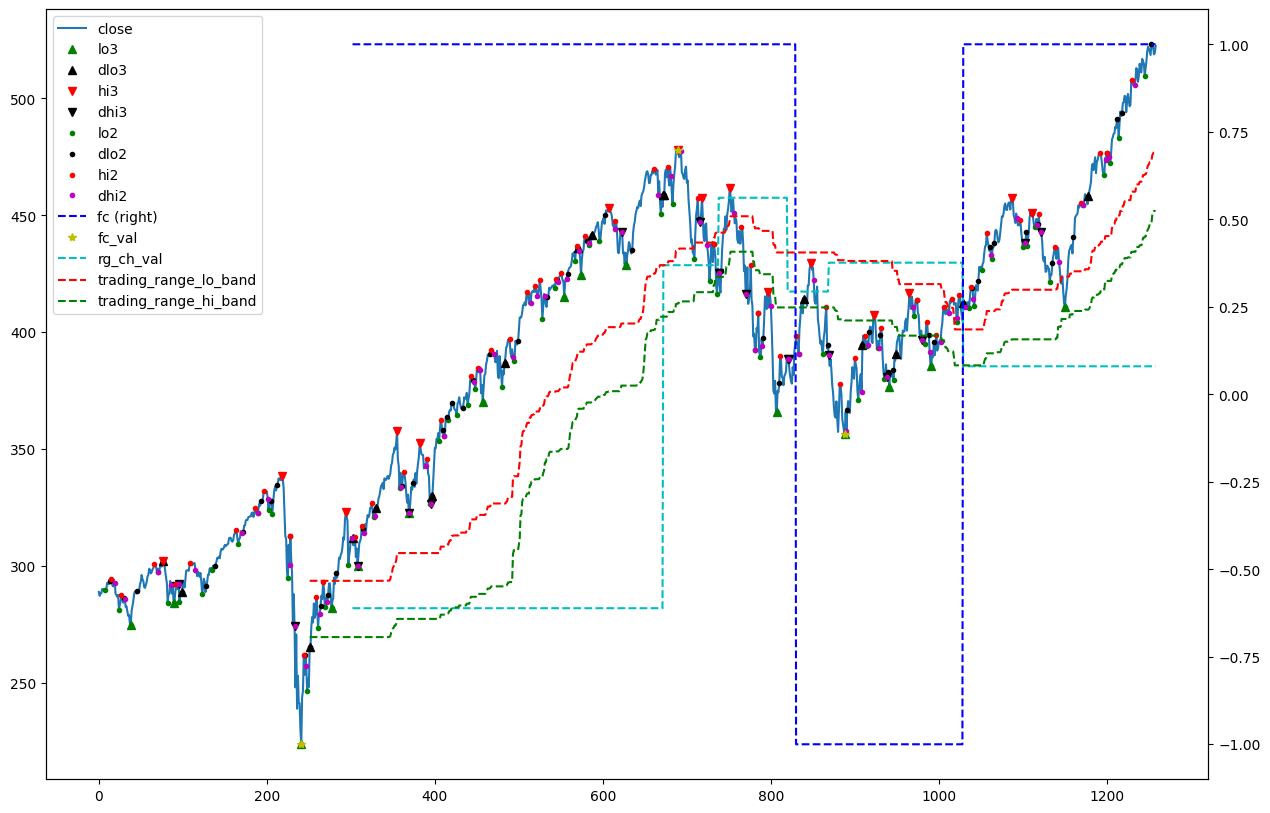

In [7]:
plot_static('SPY', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


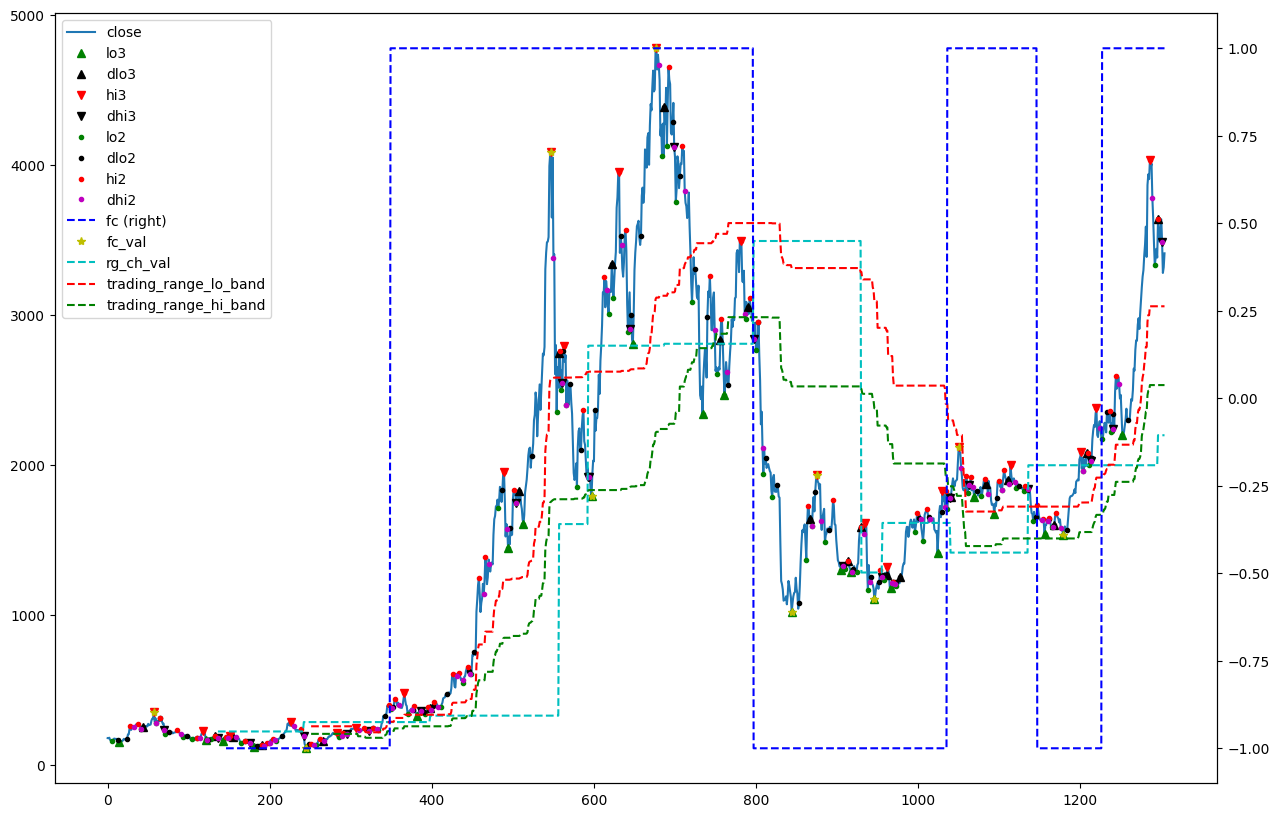

In [8]:
plot_static('ETH', 'CRYPTO', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


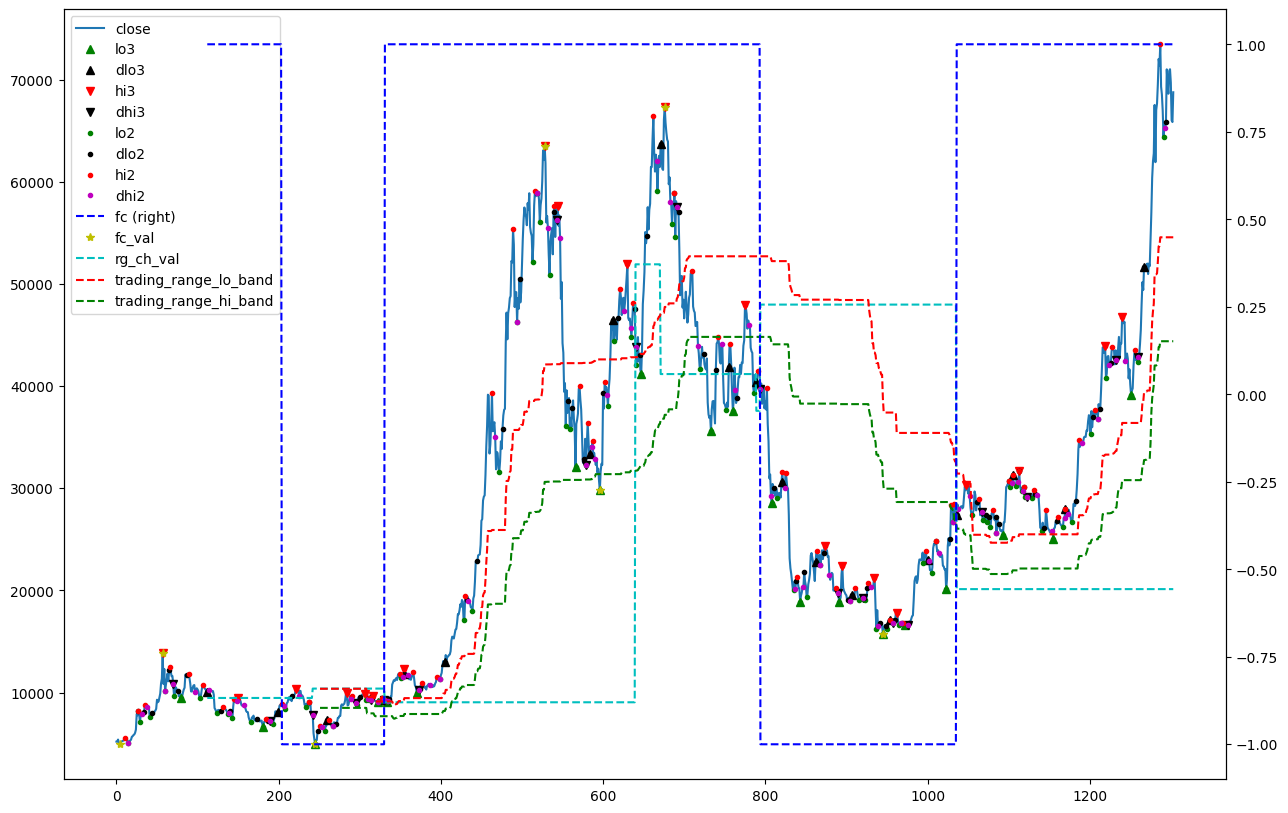

In [9]:
plot_static('BTC', 'CRYPTO', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


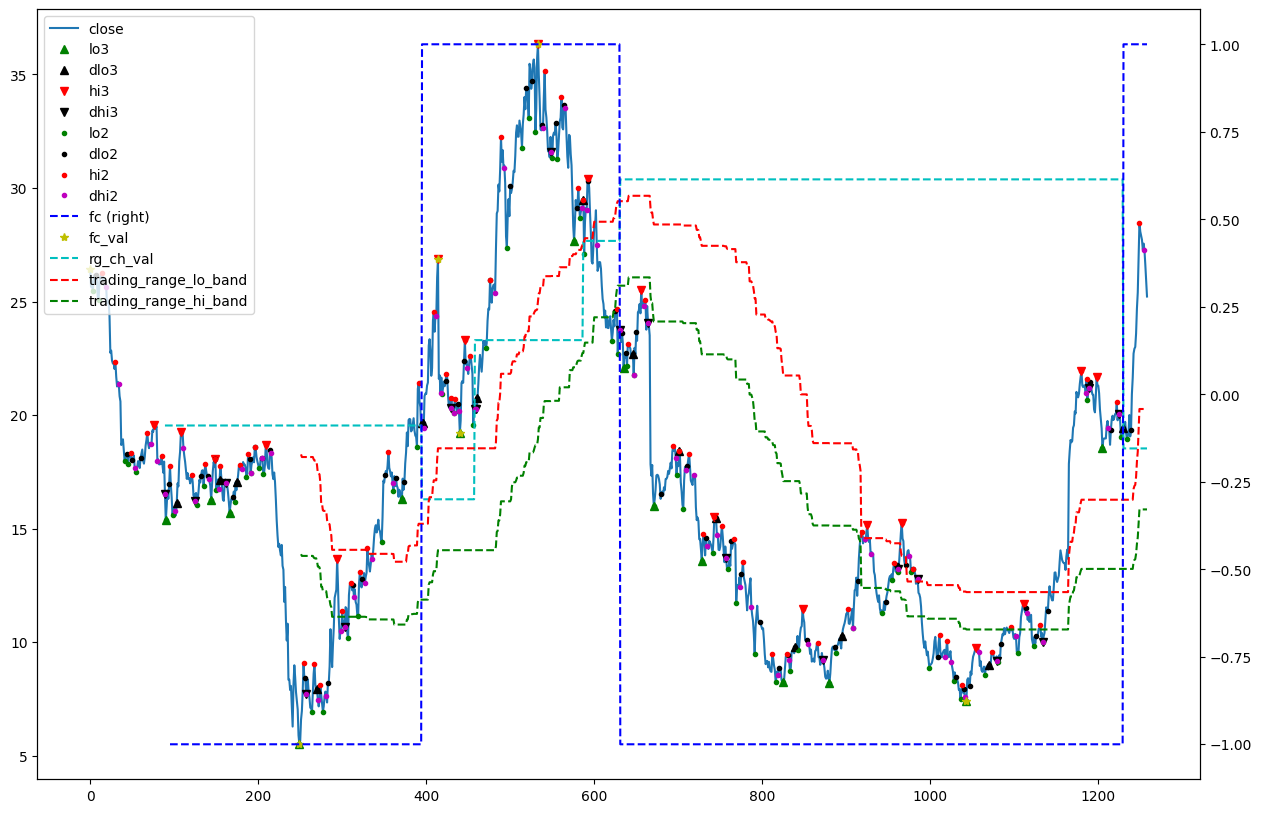

In [11]:
plot_static('GPS', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


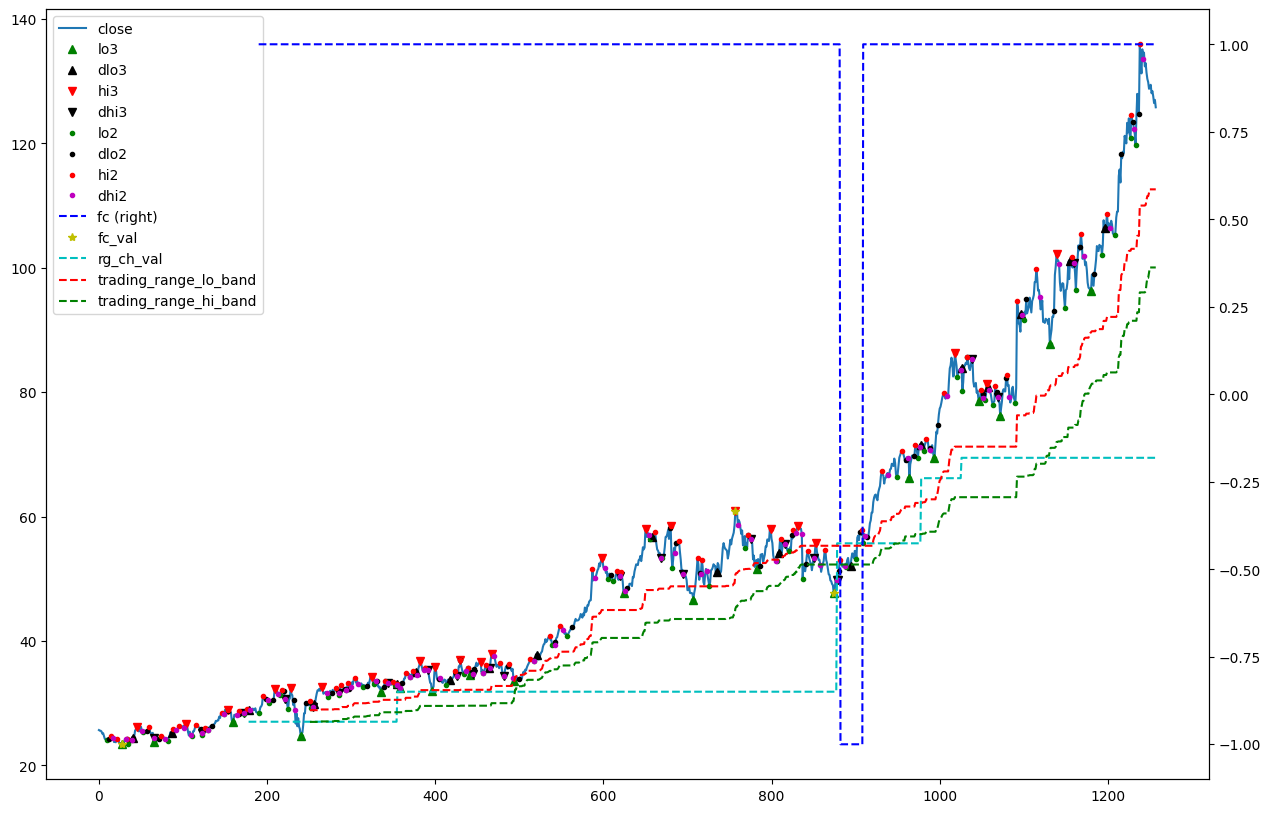

In [12]:
plot_static('NVO', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


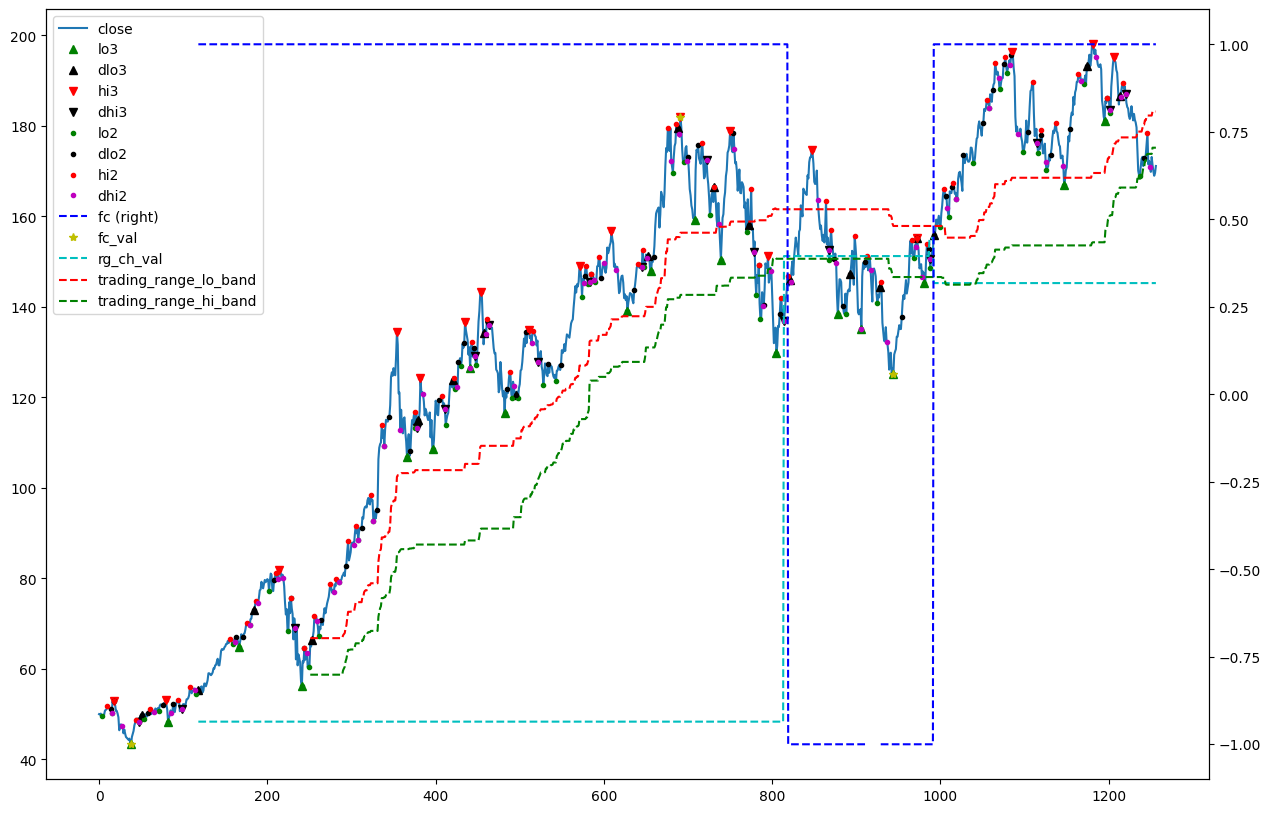

In [13]:
plot_static('AAPL', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


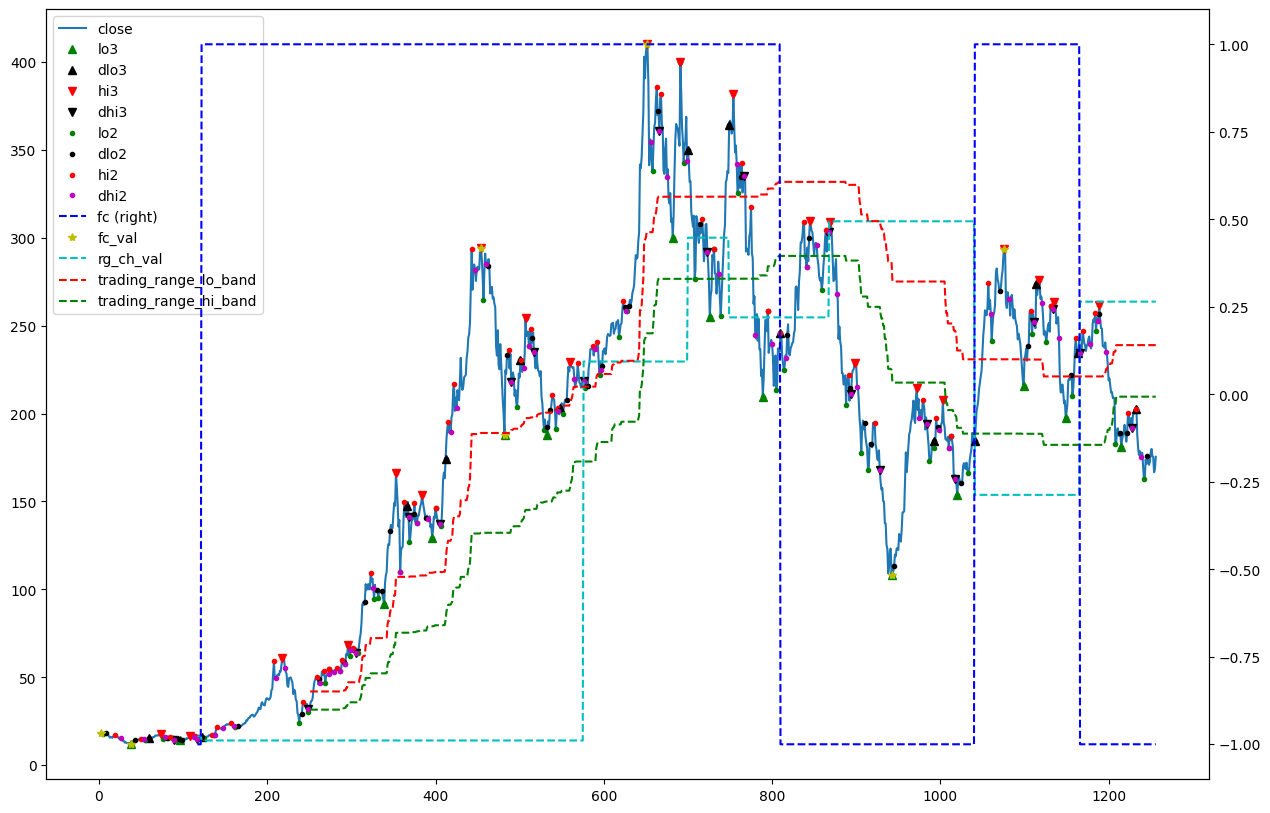

In [14]:
plot_static('TSLA', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


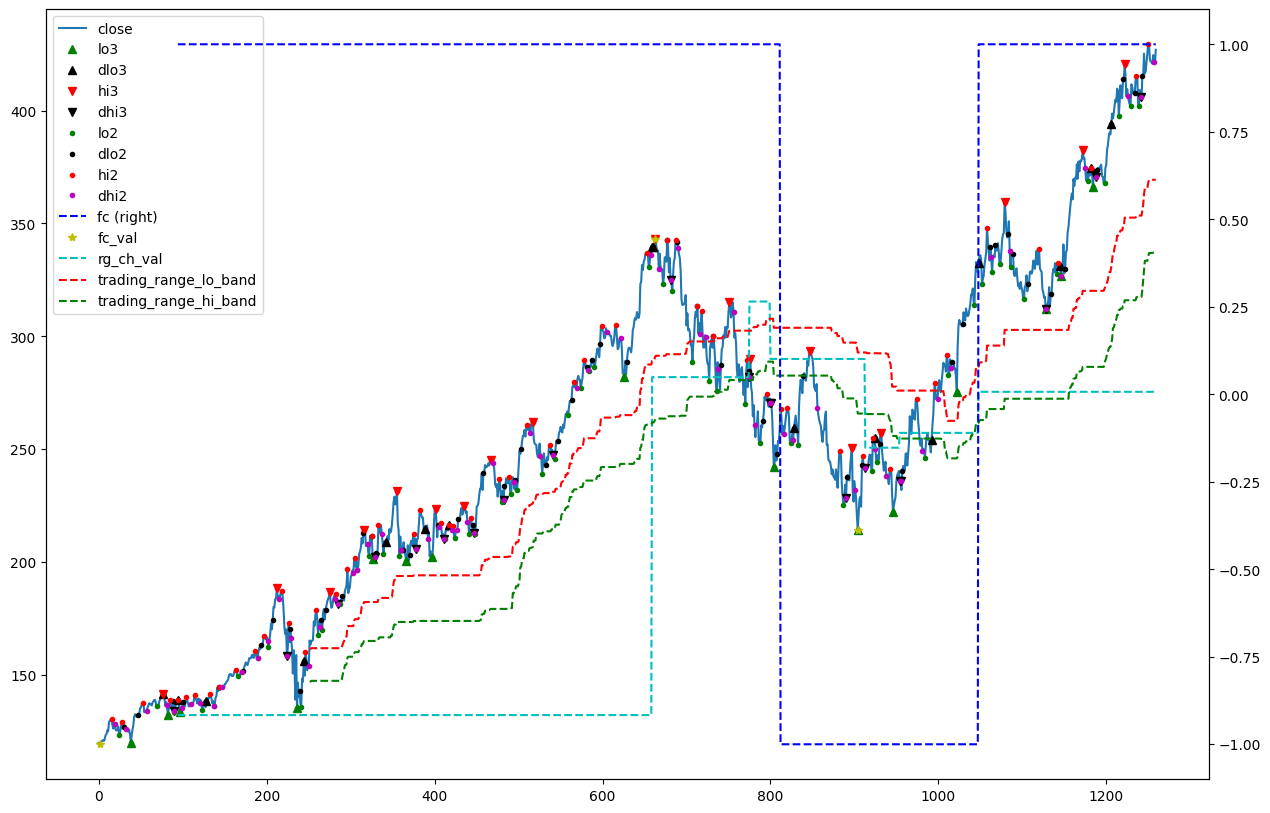

In [15]:
plot_static('MSFT', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


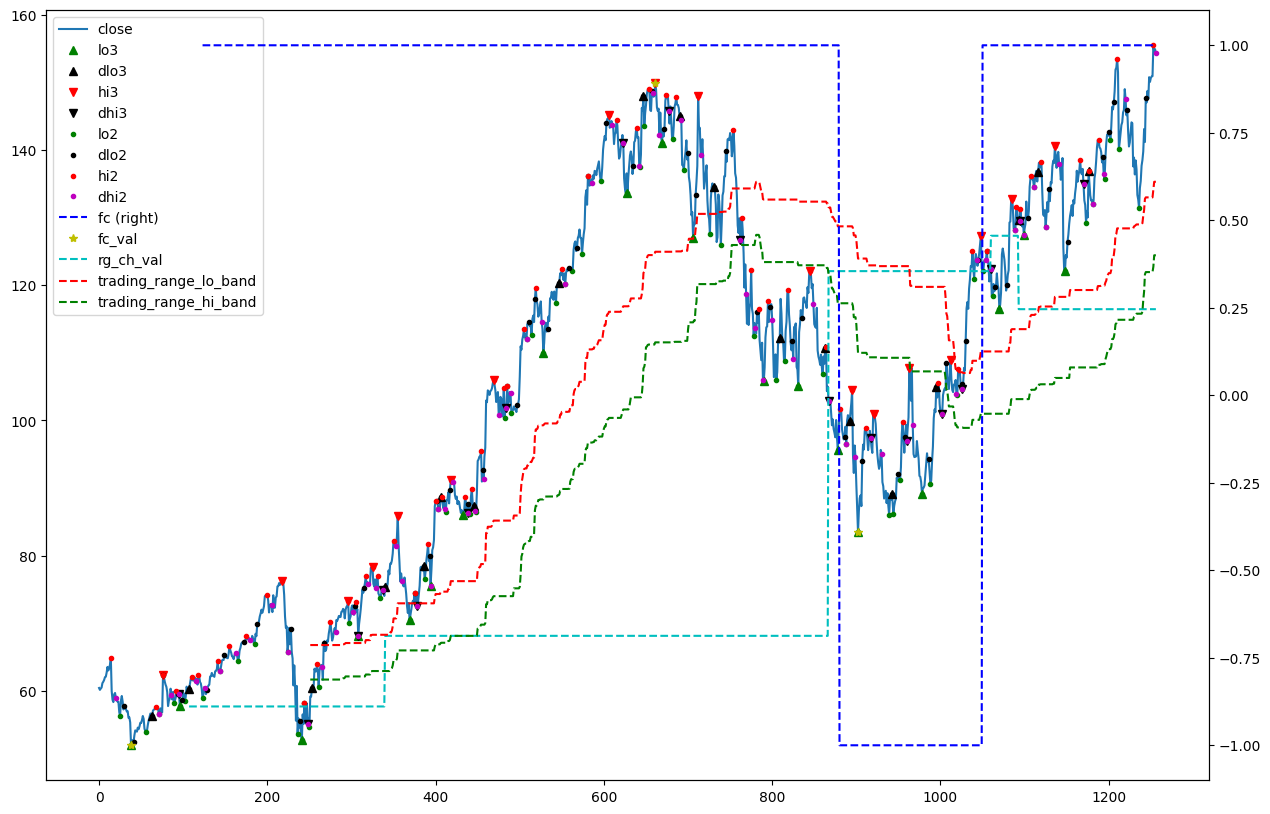

In [16]:
plot_static('GOOGL', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


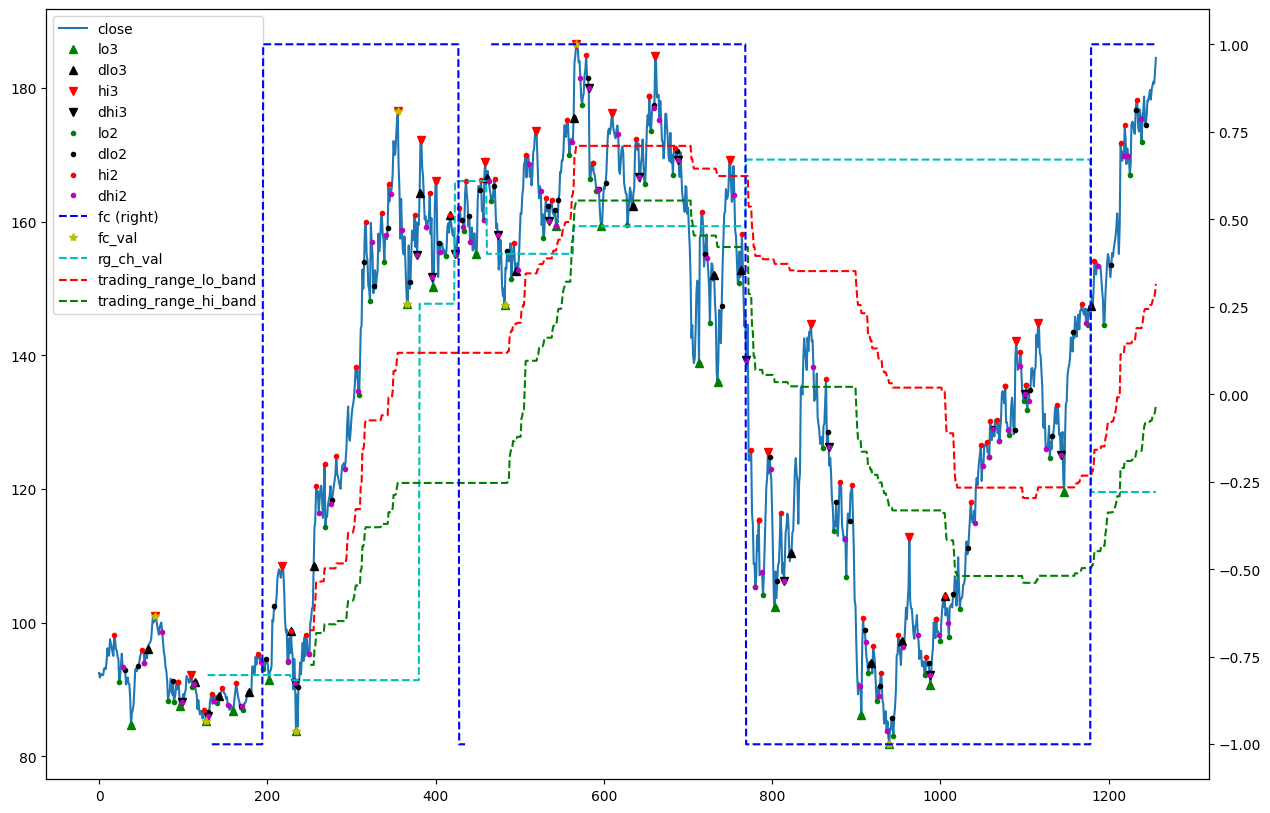

In [17]:
plot_static('AMZN', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


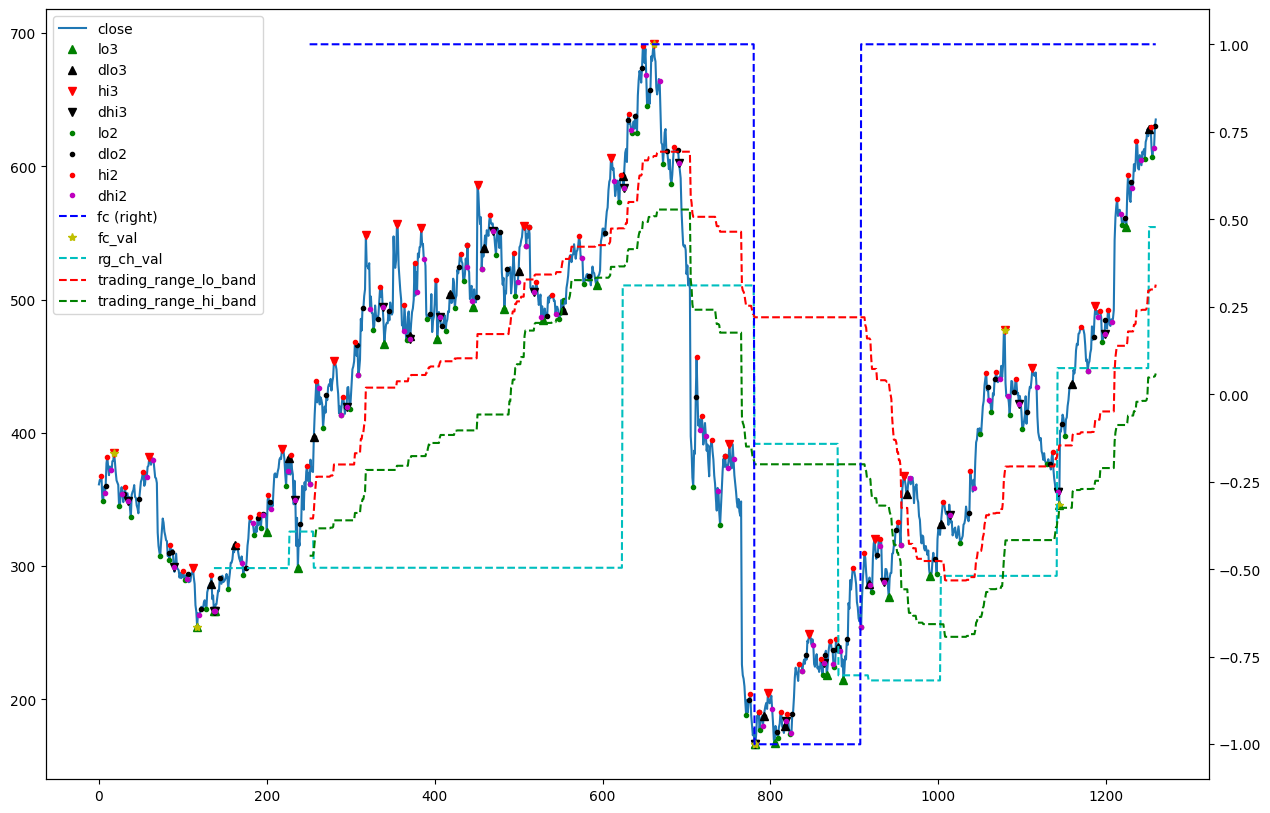

In [18]:
plot_static('NFLX', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


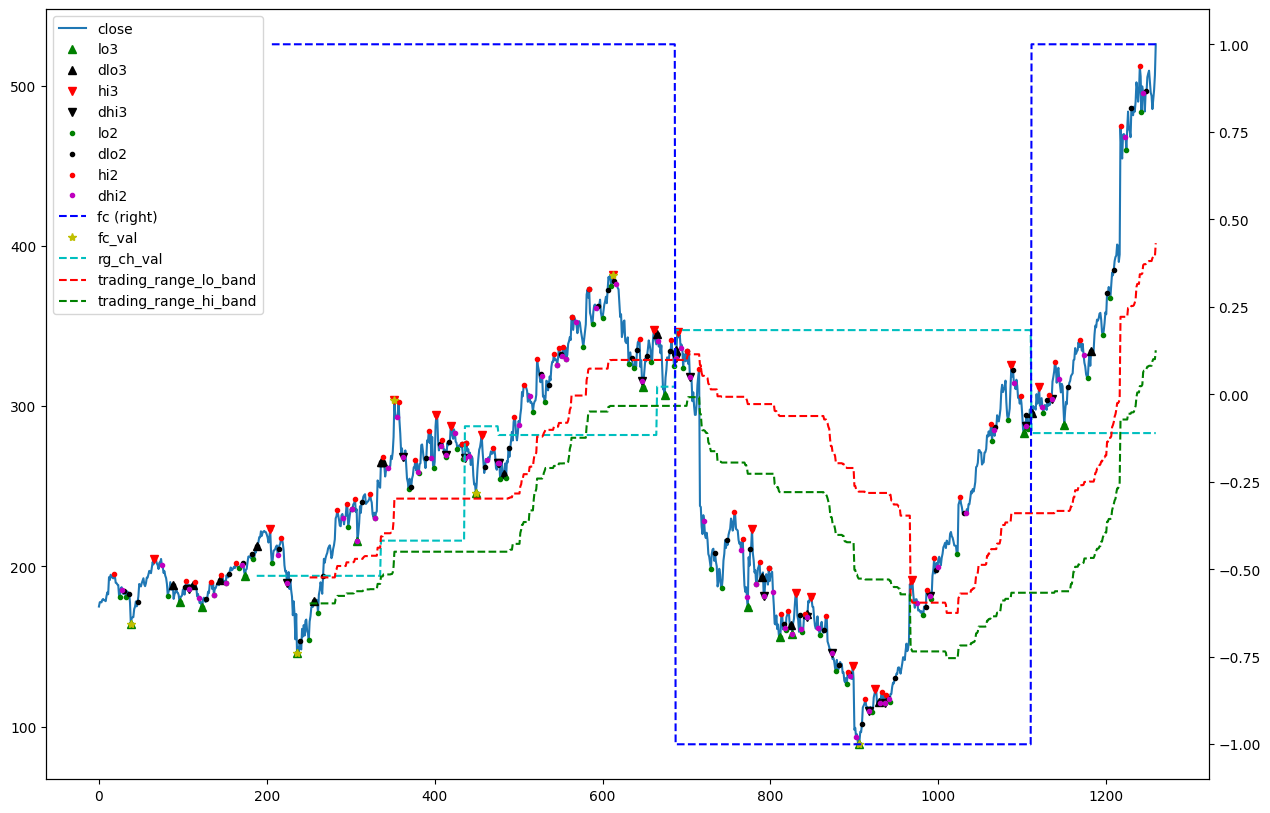

In [19]:
plot_static('META', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


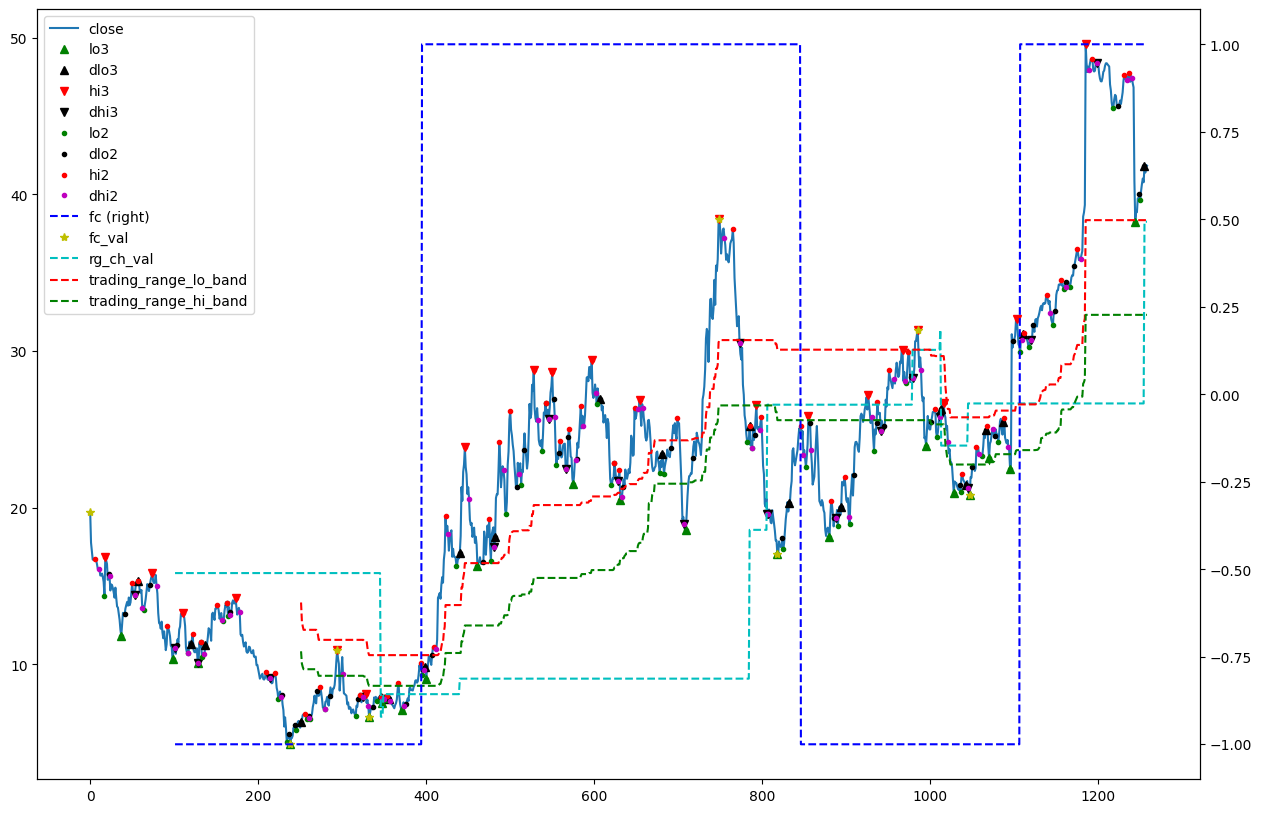

In [20]:
plot_static('X', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


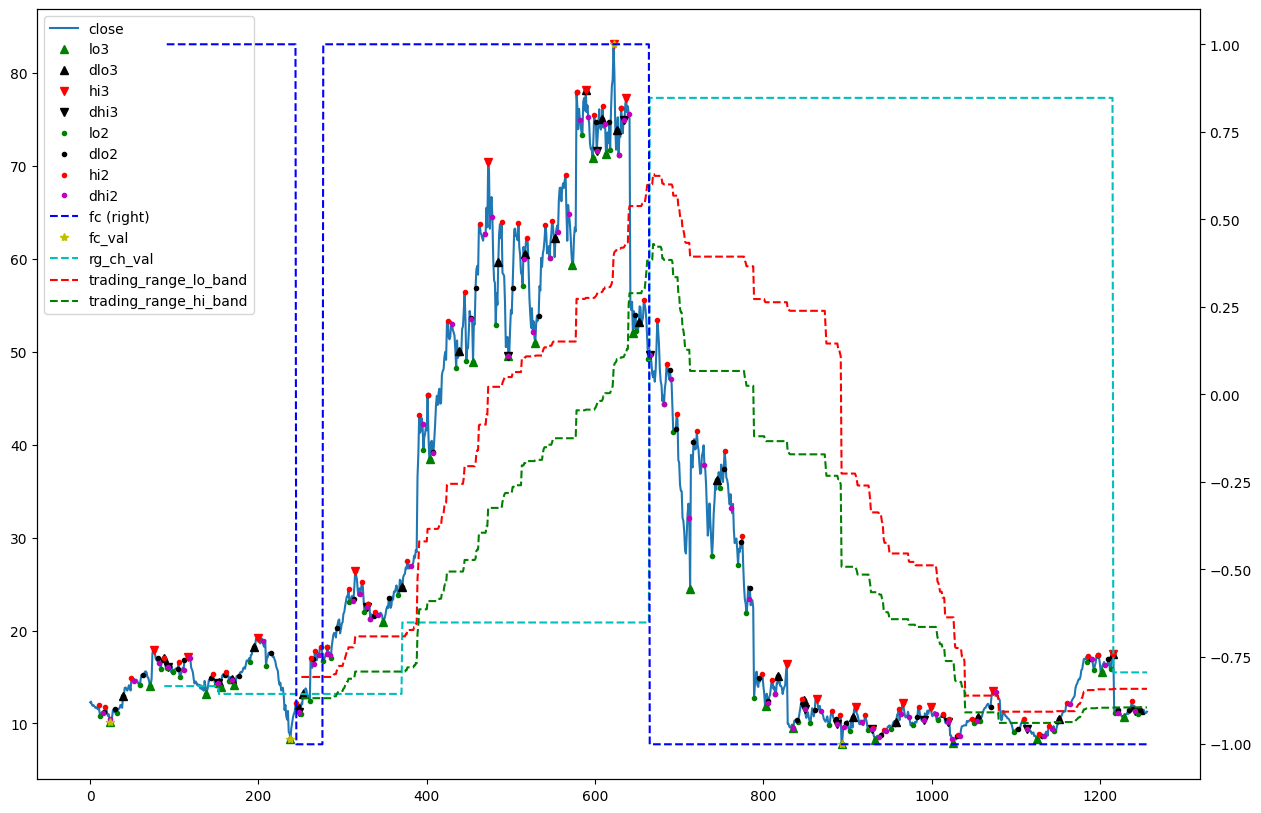

In [21]:
plot_static('SNAP', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


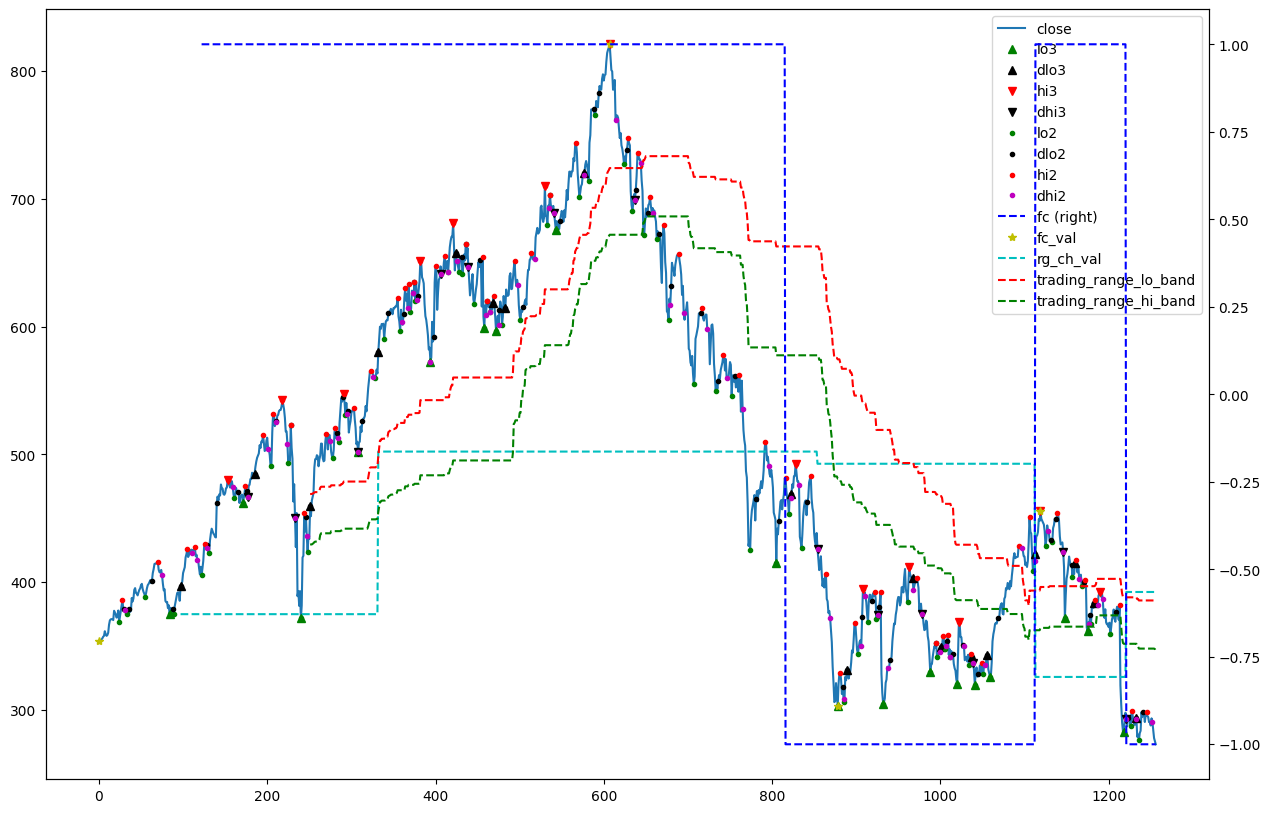

In [22]:
plot_static('CHTR', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


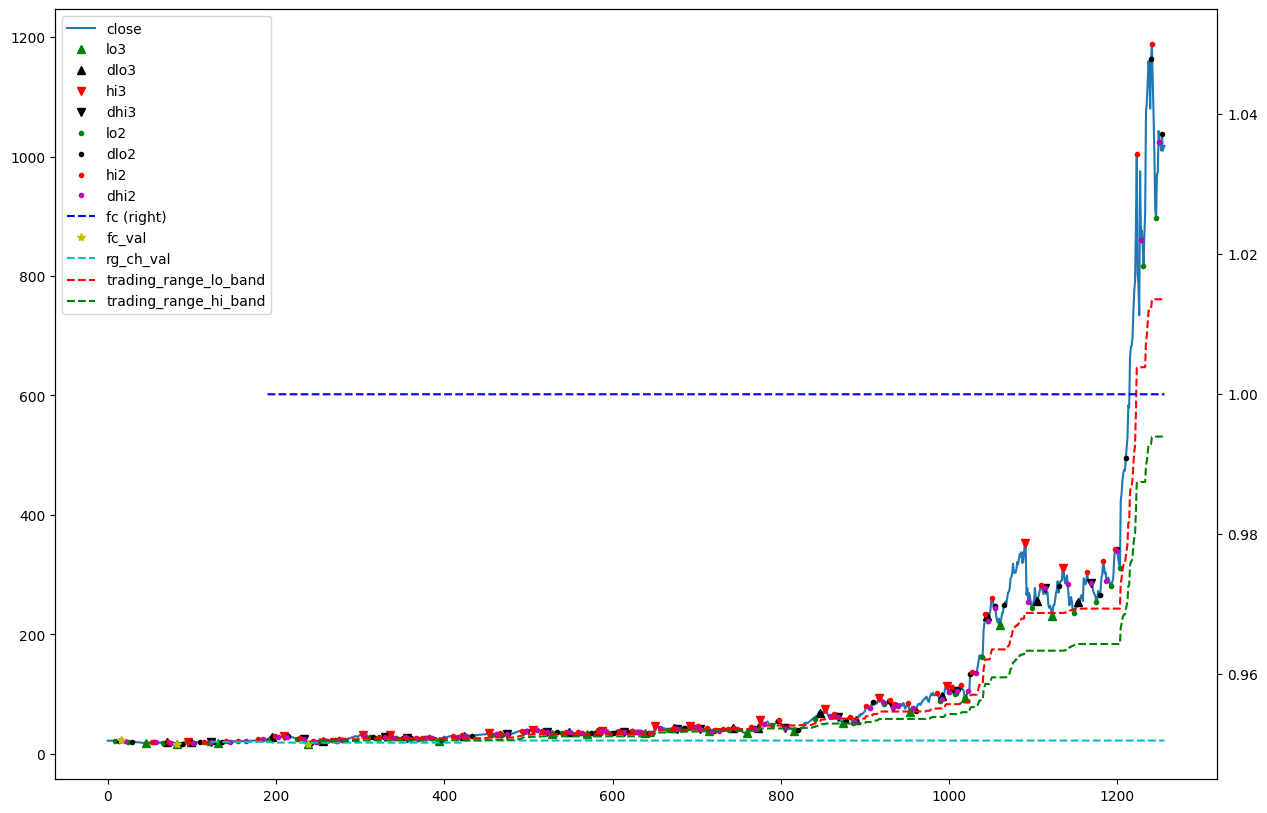

In [23]:
plot_static('SMCI', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

/home/brian/repos/backtest_notebook/venv/lib/python3.10/site-packages/src/regime/utils.py:776: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[rg_ch] = df[rg_ch].ffill()
/home/brian/repos/backtest_notebook/scripts/trend_viewer.py:143: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  _stock_data.rg_ch_val = _stock_data.rg_ch_val.ffill()


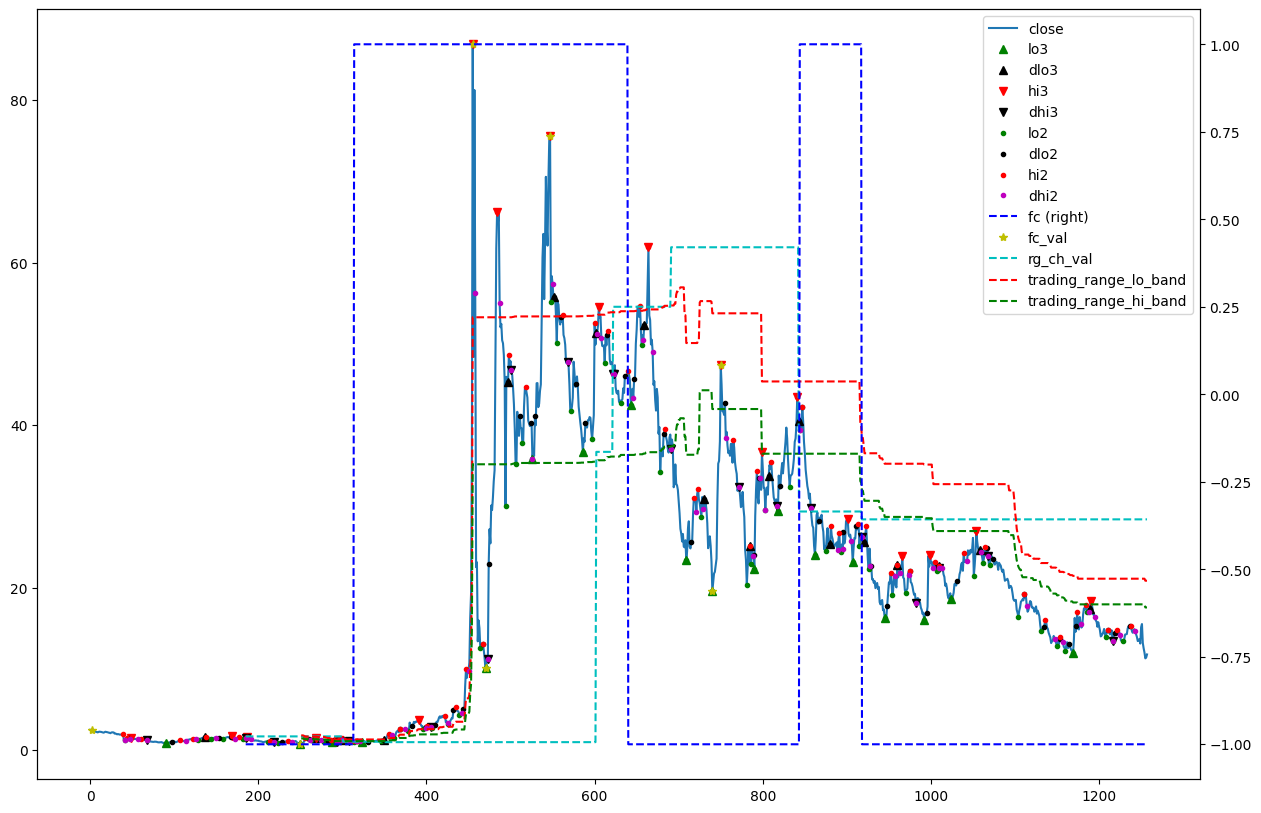

In [24]:
plot_static('GME', 'STK', _interval, _duration, use_rth=True, find_retest_swing=False, plot_window=3000)

In [ ]:
# plot_static('BTC', 'CRYPTO', '15 mins', "3 M", use_rth=True, find_retest_swing=False, plot_window=3000)

In [ ]:
# plot_static('ETH', 'CRYPTO', '15 mins', "3 M", use_rth=True, find_retest_swing=False, plot_window=3000)

In [25]:
import notes.regime_classic as regime_classic

# for reference

start = '2023-1-1'
end = None
vlty_n = 63
dist_pct = 0.05
retrace_pct = 0.05
threshold = 1.5
dgt = 2
d_vol = 5
r_vol = 2.5
lvl = 3

def ib_get_historical(symbol, sec_type, duration, interval, use_rth=True): 
    contracts = ib.reqContractDetails(Contract(symbol=symbol, secType=sec_type, includeExpired=False))[0]
    contract = contracts.contract
    bars = ib.reqHistoricalData(
        contract,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=interval,
        whatToShow='TRADES' if symbol not in ['BTC', 'ETH'] else 'AGGTRADES',
        useRTH=use_rth,
        formatDate=1,
        keepUpToDate=False
    )
    prices = util.df(bars)
    prices.index = prices.date 
    prices = prices.drop(columns=['date'])
    return prices

s = "ETH"
price_data = ib_get_historical(s, "CRYPTO", "5 Y", "1 day")
bench_data = ib_get_historical("SPY", "STK", "5 Y", "1 day")


price_data_with_swings = regime_classic.swings(price_data, bench_data, 'close', None, None, None, lvl, d_vol, dist_pct, vlty_n, r_vol, retrace_pct, dgt)
price_data_with_regime = regime_classic.regime(price_data_with_swings, 3, vlty_n, threshold)

regime_table = fcr.regime_ranges(price_data_with_regime, "rg")

/home/brian/repos/backtest_notebook/notes/regime_classic.py:275: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reduction.fillna(method='ffill', inplace=True)
/home/brian/repos/backtest_notebook/notes/regime_classic.py:275: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reduction.fillna(method='ffill', inplace=True)
/home/brian/repos/backtest_notebook/notes/regime_classic.py:275: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reduction.fillna(method='ffill', inplace=True)
/home/brian/repos/backtest_notebook/notes/regime_classic.py:275: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  reduction.fillna(method='ffill', inplace=True)


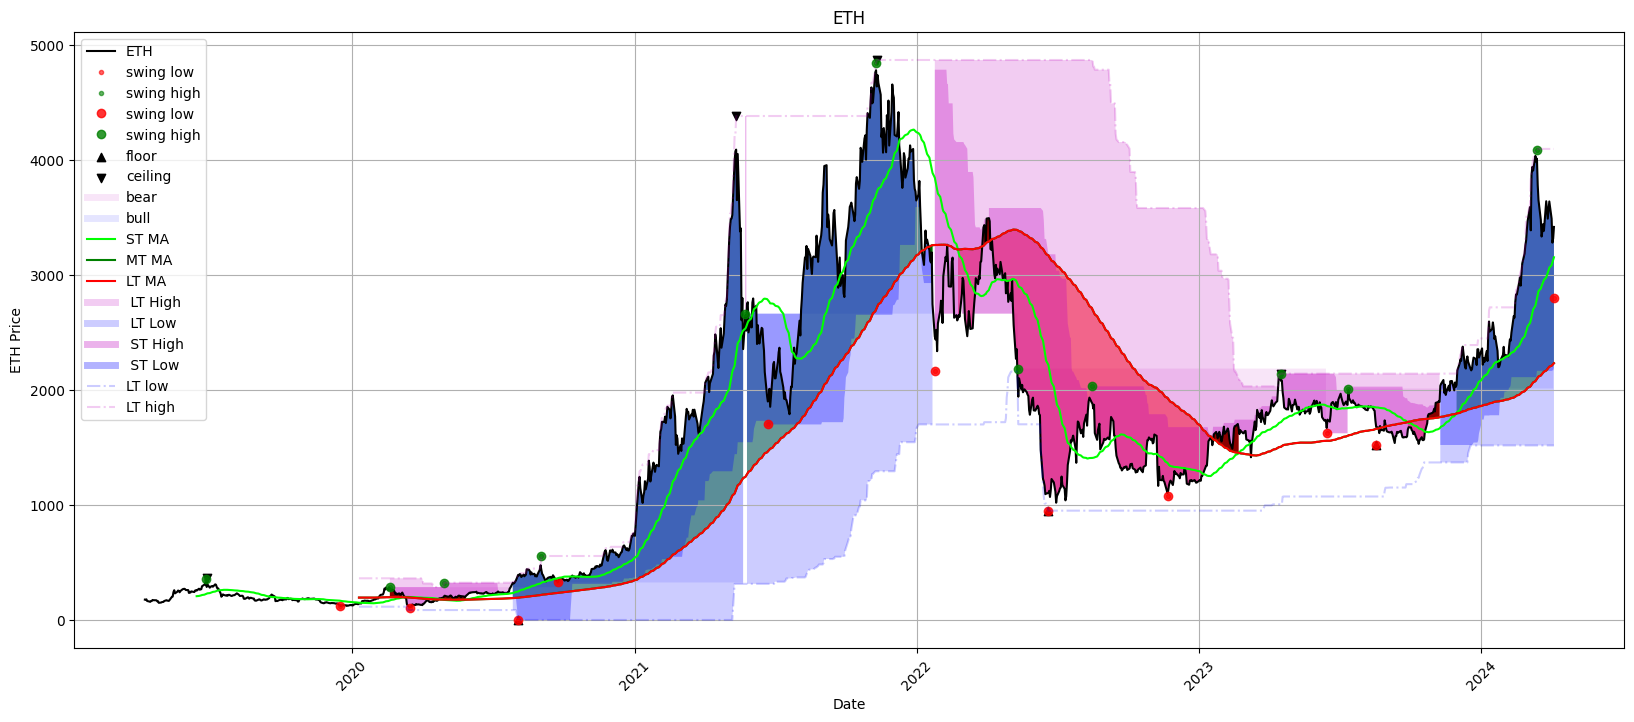

In [28]:
st= fast = 50
lt = slow = 200
mav = [fast, slow, 200]
bo = [fast, slow]
_o,_h,_l,_c = regime_classic.lower_upper_OHLC(price_data_with_regime,relative = False)
ma_st,ma_mt,ma_lt = [price_data_with_regime[_c].rolling(mav[t]).mean() for t in range(len(mav))]
st_lo,lt_lo = [price_data_with_regime[_l].rolling(bo[t]).min() for t in range(len(bo))]
st_hi,lt_hi = [price_data_with_regime[_h].rolling(bo[t]).max() for t in range(len(bo))]
rg_combo = ['close','rg','lo'+str(lvl),'hi'+str(lvl),'lo'+str(lvl),'hi'+str(lvl),'clg','flr','rg_ch']
_c,rg,lo,hi,slo,shi,clg,flr,rg_ch =[rg_combo[r] for r in range(len(rg_combo)) ]
regime_classic.graph_regime_combo(s, price_data_with_regime, _c, rg, lo, hi, slo, shi, clg, flr, rg_ch, ma_st, ma_mt, ma_lt, lt_lo, lt_hi, st_lo, st_hi)

In [29]:
import pandas as pd

move_avg_table = pd.DataFrame({
    'close': price_data_with_regime['close'],
    'fast': ma_st,
    'slow': ma_mt,
    '200': ma_lt,
})

move_avg_table['signal'] = (move_avg_table['fast'] > move_avg_table['slow']).astype(int) * 2 - 1
move_avg_regime_table = fcr.regime_ranges(move_avg_table, 'signal')


start_prices = move_avg_table.loc[move_avg_table.index.isin(move_avg_regime_table.start), 'close']
end_prices = move_avg_table.loc[move_avg_table.index.isin(move_avg_regime_table.end), 'close']


def calc_returns(signal, entry_price, exit_price):
    return signal * (entry_price - exit_price)

def calculate_max_gains(price_table, regime_table, signal_column='signal', close_column='close', start_column='start', end_column='end'):
    """
    Calculates the potential gains based on the price and regime tables.

    Parameters:
    - price_table (DataFrame): The table containing price data.
    - regime_table (DataFrame): The table containing regime data.
    - signal_column (str): The column name in the regime table indicating the signal (default: 'signal').
    - close_column (str): The column name in the price table indicating the closing price (default: 'close').
    - start_column (str): The column name in the regime table indicating the start date (default: 'start').
    - end_column (str): The column name in the regime table indicating the end date (default: 'end').

    Returns:
    - total_gain (float): The sum of potential gains.
    - potential_gains (Series): The series containing the potential gains.

    """
    potential_gains = []

    for _, row in regime_table.iterrows():
        start_date = row.start
        end_date = row.end
        prices = price_table.loc[(price_table.index >= start_date) & (price_table.index <= end_date)]
        
        # symetrical definition of the value we are looking for regardless of bull or bear signal
        max_value = (row.signal * prices.close).max() * row.signal

        potential_gains.append(max_value)

    
    return pd.Series(potential_gains)

# selected_prices is a list of DataFrames, each containing the selected prices for a row in move_avg_regime_table
diff = move_avg_regime_table.signal * (end_prices.reset_index(drop=True) - start_prices.reset_index(drop=True))
print(calc_returns(move_avg_regime_table.signal, start_prices.reset_index(drop=True), end_prices).sum())
calculate_max_gains(move_avg_table, move_avg_regime_table)


0.0


/tmp/ipykernel_97290/943213785.py:19: RuntimeWarning: '<' not supported between instances of 'datetime.date' and 'int', sort order is undefined for incomparable objects.
  return signal * (entry_price - exit_price)


0     121.50
1     202.45
2     187.50
3    4777.95
4    1019.95
5    2116.20
6    1531.15
7    4033.30
dtype: float64

<Axes: xlabel='date'>

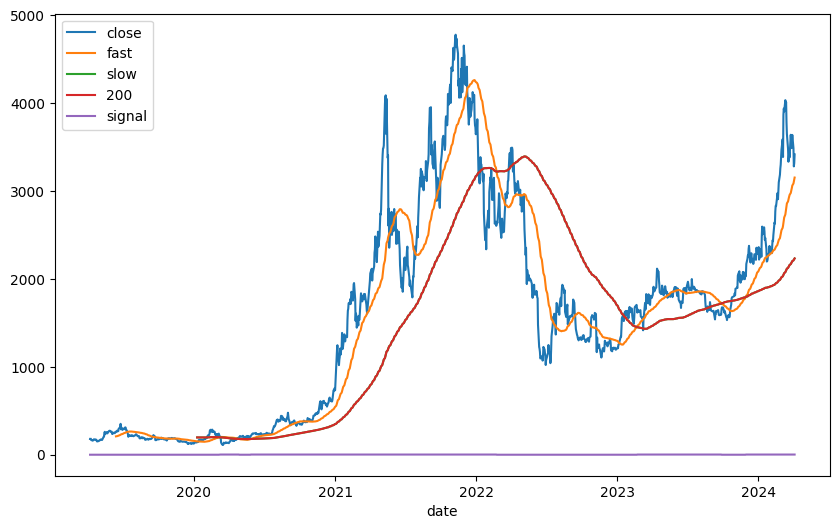

In [30]:

move_avg_table.plot(figsize=(10, 6))

In [132]:


from abc import ABC, abstractmethod
from copy import copy


class IndicatorCollection:
    def __init__(self):
        self._indicators = []

    def add(self, indicator):
        self._indicators.append(indicator)
        return indicator

    def update(self, value):
        for indicator in self._indicators:
            indicator.update(value)
    
    def __iter__(self):
        return iter(self._indicators)



class Indicator(ABC):
    """Indicators define how calculations are made"""
    _indicators: IndicatorCollection
    
    def __init__(self):
        self.__value = None
        self._indicators = IndicatorCollection()

    def update(self, value):
        self._indicators.update(value)
        return self._update(value)

    @abstractmethod
    def _update(self, value):
        raise NotImplementedError
    

    @property
    def _value(self):
        return copy(self.__value)
    
    @_value.setter
    def _value(self, value):
        self.__value = value

    @property
    def value(self):
        return self._value


class MoveAvg(Indicator):
    def __init__(self, window):
        super().__init__()
        self._window = window

    def __get__(self):
        return self._value


class MoveAvgVector(MoveAvg):
    def _update(self, value):
        self._value = value.rolling(self._window).mean()
        return self._value


class MoveAvgCrossVector(Indicator):
    def __init__(self, fast, slow):
        assert fast < slow
        super().__init__()
        self._slow = self._indicators.add(MoveAvgVector(slow))
        self._fast = self._indicators.add(MoveAvgVector(fast))

    def _update(self, value):
        self._value = self._fast.update(value) - self._slow.update(value)
        return self._value
    
    
def regime_ranges(signal):
    """
    Given a DataFrame and a column name, returns a DataFrame with the start and end indices of each regime in the column.

    Args:
        df (pandas.DataFrame): The DataFrame containing the regime column.
        rg_col (str): The name of the regime column.

    Returns:
        pandas.DataFrame: A DataFrame with the start and end indices of each regime in the column.
    """
    start_col = "start"
    end_col = "end"
    signal_col = "signal"
    loop_params = [(start_col, signal.shift(1)), (end_col, signal.shift(-1))]
    boundaries = {}
    for name, shift in loop_params:
        rg_boundary = signal.loc[
            ((signal == -1) & (pd.isna(shift) | (shift != -1)))
            | ((signal == 1) & ((pd.isna(shift)) | (shift != 1)))
        ]
        rg_df = pd.DataFrame(data={signal_col: rg_boundary})
        rg_df.index.name = name
        rg_df = rg_df.reset_index()
        boundaries[name] = rg_df

    boundaries[start_col][end_col] = boundaries[end_col][end_col]
    return boundaries[start_col][[start_col, end_col, signal_col]]


class Strategy(Indicator, ABC):
    def __init__(self):
        super().__init__()
        self._log = pd.DataFrame()

    def is_ready(self) -> bool:
        return self._value is not None and len(self._log) > 0
    
    @property
    def _value(self):
        return self.__value
    
    @_value.setter
    def _value(self, value):
        self.__value = value
        self._update_log()
    
    def _update_log(self):
        raise NotImplementedError
    
    @property
    def log(self):
        return self._log
    

class VectorStrategy(Strategy):
    def __init__(self):
        super().__init__()

    def _update_log(self):
        self._log = regime_ranges(self._value)

    
class EventStrategy(Strategy, ABC):
    def __init__(self):
        super().__init__()

    def log(self):
        """
        For event based strategy implementation:
            - if signal is None, do nothing
            - if signal == log[-1], update log[-1].end to current index
            - if signal != log[-1], add new row to log with start = current index
        """


class XOverStrat(VectorStrategy):
    """
    Strategies use indicators and price to define entry and exit logic
    """
    def __init__(self, slow, fast):
        super().__init__()
        self._xover = self._indicators.add(MoveAvgCrossVector(slow, fast))

    def _update(self, value):
        """value set to 1 when fast > slow, -1 slow > fast"""
        res = self._xover.value
        res[res > 0] = 1
        res[res < 0] = -1
        self._value = res

    
class XOverStratEvent:
    def _update(self, value):
        res = self._xover.update(value)
        self._value = 1 if res > 0 else -1

In [133]:
MoveAvgCrossVector(50, 200).update(price_data_with_regime['close'])

date
2019-04-08          NaN
2019-04-09          NaN
2019-04-10          NaN
2019-04-11          NaN
2019-04-12          NaN
                ...    
2024-03-29    859.84650
2024-04-01    874.65150
2024-04-02    889.37100
2024-04-03    904.27550
2024-04-04    920.41525
Name: close, Length: 1304, dtype: float64

In [134]:
"""
TODO: logself._value =dicator == positive, bear signal: all_indicators == negative

- From log + price tables, derive a min and max table tracking the min and max theoretical gains for each regime
    - measure how much the strategy is leaving on the table

Stats Class(es) features:
    - can generate stats from strategy log for fast stat calculation
    - can generate rolling stats after signals are applied to price history

- Stats object should be able to:
    - calculate returns (arithemtic, log) based on strategy log
    - calculate max gains based on strategy log
    - calculate other stats based on strategy log
    - win/loss rate
    - average win/loss
    - expectency (win rate * avg win - loss rate * avg loss)
    - drawdown
    - sharpe ratio
    - etc.
"""
xover_strat = XOverStrat(50, 200)
xover_strat.update(price_data_with_regime['close'])
xover_strat.log

,start,end,signal
0,2020-01-10,2020-03-06,-1.0
1,2020-03-09,2020-04-27,1.0
2,2020-04-28,2020-05-27,-1.0
3,2020-05-28,2022-02-22,1.0
4,2022-02-23,2023-02-21,-1.0
5,2023-02-22,2023-09-27,1.0
6,2023-09-28,2023-11-29,-1.0
7,2023-11-30,2024-04-04,1.0
